# MNIST Classification

## Get the data

In [2]:
from sklearn.datasets import fetch_openml

mnist=fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [79]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.base import clone, BaseEstimator
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

## Analyse the data

In [4]:
#get data and labels
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

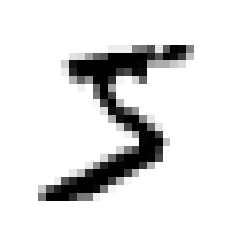

In [6]:
#Look into one of the digits
X=X.to_numpy()
some_digit=X[0]
some_digit_image=some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [7]:
y[0]

'5'

## Prepare training set and test set

In [8]:
#convert string label to integer
y=y.astype(np.uint8)

In [9]:
#mnist is already split into training set and test set
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Binary classifier

Classifier to identify "5" or "not a 5"

In [10]:
#create traget vectors
y_train_5 = (y_train==5)
y_test_5 = (y_test==5)

y_train_5

0         True
1        False
2        False
3        False
4        False
         ...  
59995    False
59996    False
59997     True
59998    False
59999    False
Name: class, Length: 60000, dtype: bool

In [11]:
y_train_5.unique()

array([ True, False])

train stochastic gradient classifier

In [12]:
sgd_clf=SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [13]:
#check for some_digit (should be true)
sgd_clf.predict([some_digit])

array([ True])

## Measure Accuracy using cross-validation

In [14]:
#custom cross validation function similar to sklearn cross_val_score
skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf=clone(sgd_clf)
    X_train_folds=X_train[train_index]
    y_train_folds=y_train_5[train_index]
    X_test_fold=X_train[test_index]
    y_test_fold=y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred=clone_clf.predict(X_test_fold)
    n_correct=sum(y_pred==y_test_fold)
    print(n_correct/len(y_pred))

0.9669
0.91625
0.96785


In [15]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

## Why accuracy is not the preferred performance measure for classifiers

In [16]:
#stupid classifier that classifies each image as "not a 5"
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)

#has a accuracy of 90%:
never_5_clf=Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

## Confusion Matrix

Count the number of times instances of class A are classified as class B

| true negative  | false negative |  
| false positive | true positive  |  

In [17]:
#cross_val_predict returns teh predictions made on each fold
y_train_pred=cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

#create confusion matrix
#each row represents an actual class, each column represents a predicted class
# 53892 images were classified correctly as "not a 5" (true negative)
# 687 images were classifed wrongly as "not a 5" (false negative)
# 1891 false positive
# 3530 true positive

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

## Precision, Recall & F1-score

Accuracy of the positive predictions: TP/(TP + FP)

Recall or Sensitivity or true positive rate TPR: TP/(TP + FN)

F1-score (harmonic mean of precision and recall: TP/(TP+(FN+FP)/2))

In [18]:
#How often is the predicted 5 an actual 5?
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [19]:
#How many of the 5's are detected?
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [20]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

Change threshold for recall and precision

In [21]:
#SGD classifier uses threshold 0 by default when using predict() which is the same as:
y_scores=sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [23]:
#the image of a 5 is correctly classifed
threshold=0
y_some_digit_pred=(y_scores>threshold)
y_some_digit_pred

array([ True])

In [24]:
#changing the threshold changes classification
threshold=8000
y_some_digit_pred=(y_scores>threshold)
y_some_digit_pred

array([False])

How to decide which threshold to use?

1. use cross_val_predict() to get scores of all instances in the training set and return the decision scores

In [25]:
y_scores=cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

2. Use precision_recall_curve() to compute precision and recall for all possible thresholds

In [27]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

3. Use Matplotlib to plot precision and recall as functions of the threshold value

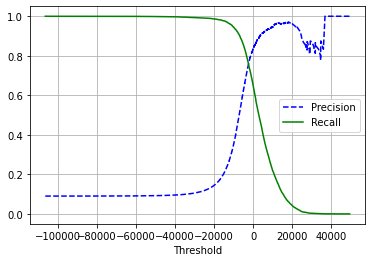

In [35]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend()
    plt.grid()
    plt.xlabel('Threshold')

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

4. Plot Recall vs Precision

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


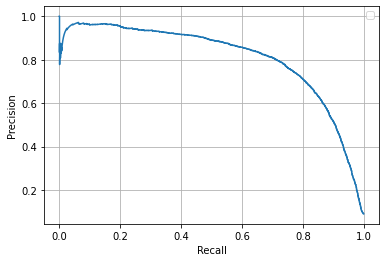

In [41]:
def plot_precision_vs_recall(precisions, recalls, thresholds):
    plt.plot(recalls[:-1], precisions[:-1] )
    plt.legend()
    plt.grid()
    plt.xlabel('Recall')
    plt.ylabel('Precision')

plot_precision_vs_recall(precisions, recalls, thresholds)
plt.show()

5. Find threshold for defined minimum precision (example: 90%)

In [43]:
threshold_90_precision=thresholds[np.argmax(precisions>=0.90)]
threshold_90_precision

3370.0194991439557

6. Make predictions with discovered threshold

In [44]:
y_train_pred_90=(y_scores>=threshold_90_precision)

#get precision
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [46]:
#get recall
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

## ROC curve

Receiver Operating Characteristic  
Plot sensitivity (recall) vs 1 - specifity (1 - true-negative-ratio)

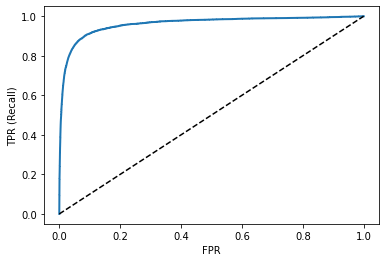

In [49]:
#compute FPR and TPR
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

#plot FPR vs TPR
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1], 'k--')
    plt.xlabel('FPR')
    plt.ylabel('TPR (Recall)')

plot_roc_curve(fpr, tpr)
plt.show()

Compare classifiers by measuring the area under the ROC curve

Perfect classifier --> Area=1  
Bad classifier --> Area=0.5

In [51]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

### Precision/Recall curve vs ROC: Which to choose

Rule of thumb:  
Prefer Prec./Recall whenever the positive class is rare or when you care more about the FPR than FNR, otherwise use ROC


### Compare random forest classidier to SGD classifier

Train random forest classifier

In [53]:
forest_clf=RandomForestClassifier(random_state=42)
y_probas_forest=cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

Use positive class's probability as score

In [54]:
y_scores_forest=y_probas_forest[:,1] #score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest=roc_curve(y_train_5, y_scores_forest)

Compare ROC curves of random forest and SGD

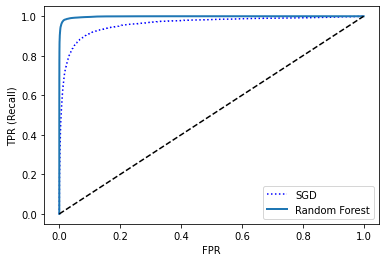

In [55]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

In [57]:
#random forest AUC score
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## Multiclass Classification

Use support vector machine to predict digit

In [59]:
svm_clf=SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In this case SVM uses one-versus-one strategy to make a prediction

In [60]:
some_digit_scores=svm_clf.decision_function([some_digit])
some_digit_scores
# returns one score per class(digits 0-9) - the higher the score the more likely the class is chosen

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [62]:
np.argmax(some_digit_scores)
# digit 5 wins

5

Forcing to use one-versus-one or one-vs-the-rest can be done with OneVsOneClassifier or OneVsRestClassifier respectively

In [64]:
ovr_clf=OneVsRestClassifier(SVC())
ovr_clf.fit(X_train,y_train)
ovr_clf.predict([some_digit])

KeyboardInterrupt: 

SGD classifier

In [65]:
sgd_clf=SGDClassifier(verbose=True)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 6666.13, NNZs: 618, Bias: -189.275511, T: 60000, Avg. loss: 38948.358218
Total training time: 0.09 seconds.
-- Epoch 2
Norm: 4256.14, NNZs: 629, Bias: -204.554897, T: 120000, Avg. loss: 5091.987635
Total training time: 0.17 seconds.
-- Epoch 3
Norm: 3149.96, NNZs: 636, Bias: -211.645650, T: 180000, Avg. loss: 2881.621721
Total training time: 0.25 seconds.
-- Epoch 4
Norm: 2624.56, NNZs: 636, Bias: -217.233959, T: 240000, Avg. loss: 1947.140981
Total training time: 0.37 seconds.
-- Epoch 5
Norm: 2292.97, NNZs: 638, Bias: -221.501755, T: 300000, Avg. loss: 1535.319528
Total training time: 0.45 seconds.
-- Epoch 6
Norm: 2037.49, NNZs: 641, Bias: -224.566402, T: 360000, Avg. loss: 1254.134171
Total training time: 0.59 seconds.
-- Epoch 7
Norm: 1834.42, NNZs: 642, Bias: -227.013689, T: 420000, Avg. loss: 989.859905
Total training time: 0.68 seconds.
-- Epoch 8
Norm: 1667.86, NNZs: 642, Bias: -229.219982, T: 480000, Avg. loss: 916.180380
Total training time: 0.76 seconds.
--

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.7min finished


array([5], dtype=uint8)

In [66]:
#SGD classifier is very confident in predicting the correct digit in this example
sgd_clf.decision_function([some_digit])

array([[-12231.07644642, -26753.71341381, -11537.26206838,
         -2990.05232284, -27139.54895565,   -597.70117741,
        -21780.72309844, -13218.42629703,  -8931.32920633,
        -17486.94361854]])

In [67]:
#check accuracy
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 9159.30, NNZs: 594, Bias: -155.161653, T: 40000, Avg. loss: 53248.560449
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 5533.45, NNZs: 612, Bias: -170.208309, T: 80000, Avg. loss: 7256.522540
Total training time: 0.10 seconds.
-- Epoch 3
Norm: 4325.57, NNZs: 618, Bias: -178.405592, T: 120000, Avg. loss: 4151.185773
Total training time: 0.16 seconds.
-- Epoch 4
Norm: 3509.30, NNZs: 624, Bias: -183.388183, T: 160000, Avg. loss: 2941.961342
Total training time: 0.21 seconds.
-- Epoch 5
Norm: 3071.45, NNZs: 628, Bias: -187.329365, T: 200000, Avg. loss: 2166.121528
Total training time: 0.28 seconds.
-- Epoch 6
Norm: 2732.67, NNZs: 628, Bias: -190.220613, T: 240000, Avg. loss: 1734.030183
Total training time: 0.35 seconds.
-- Epoch 7
Norm: 2479.61, NNZs: 631, Bias: -192.898135, T: 280000, Avg. loss: 1499.362455
Total training time: 0.41 seconds.
-- Epoch 8
Norm: 2286.72, NNZs: 631, Bias: -195.128375, T: 320000, Avg. loss: 1312.027200
Total training time: 0.47 seconds.
-

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 9033.46, NNZs: 613, Bias: -127.753134, T: 40000, Avg. loss: 51782.446192
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 5634.39, NNZs: 620, Bias: -142.480189, T: 80000, Avg. loss: 7560.141728
Total training time: 0.10 seconds.
-- Epoch 3
Norm: 4273.90, NNZs: 627, Bias: -150.541419, T: 120000, Avg. loss: 4106.595788
Total training time: 0.15 seconds.
-- Epoch 4
Norm: 3544.53, NNZs: 632, Bias: -155.360011, T: 160000, Avg. loss: 2967.383882
Total training time: 0.20 seconds.
-- Epoch 5
Norm: 3022.50, NNZs: 632, Bias: -159.479262, T: 200000, Avg. loss: 2226.346375
Total training time: 0.26 seconds.
-- Epoch 6
Norm: 2712.77, NNZs: 637, Bias: -162.657597, T: 240000, Avg. loss: 1756.585517
Total training time: 0.32 seconds.
-- Epoch 7
Norm: 2492.91, NNZs: 642, Bias: -165.161585, T: 280000, Avg. loss: 1369.291244
Total training time: 0.37 seconds.
-- Epoch 8
Norm: 2319.67, NNZs: 643, Bias: -167.692338, T: 320000, Avg. loss: 1251.017972
Total training time: 0.43 seconds.
-

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 9375.82, NNZs: 610, Bias: -165.311964, T: 40000, Avg. loss: 58779.199529
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 5711.34, NNZs: 625, Bias: -180.816050, T: 80000, Avg. loss: 8008.934367
Total training time: 0.11 seconds.
-- Epoch 3
Norm: 4396.42, NNZs: 633, Bias: -188.969427, T: 120000, Avg. loss: 4023.698076
Total training time: 0.16 seconds.
-- Epoch 4
Norm: 3633.47, NNZs: 637, Bias: -194.031249, T: 160000, Avg. loss: 2856.252690
Total training time: 0.21 seconds.
-- Epoch 5
Norm: 3124.95, NNZs: 638, Bias: -198.079115, T: 200000, Avg. loss: 2175.852265
Total training time: 0.27 seconds.
-- Epoch 6
Norm: 2850.70, NNZs: 638, Bias: -201.287227, T: 240000, Avg. loss: 1689.809110
Total training time: 0.32 seconds.
-- Epoch 7
Norm: 2574.08, NNZs: 638, Bias: -203.720787, T: 280000, Avg. loss: 1500.366239
Total training time: 0.37 seconds.
-- Epoch 8
Norm: 2381.45, NNZs: 639, Bias: -205.853391, T: 320000, Avg. loss: 1285.583356
Total training time: 0.43 seconds.
-

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.6min finished


array([0.8658 , 0.8574 , 0.87975])

A random classifier would have an accuracy of 10% (100% divided by 10 classes). Hence, the accuracy of the SGD classifier is quite good. But it can be improved, for example by scaling the features:

In [70]:
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 295.43, NNZs: 717, Bias: -1361.201352, T: 40000, Avg. loss: 10.413165
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 247.14, NNZs: 717, Bias: -1324.014242, T: 80000, Avg. loss: 2.948068
Total training time: 0.11 seconds.
-- Epoch 3
Norm: 238.05, NNZs: 717, Bias: -1301.238859, T: 120000, Avg. loss: 2.641554
Total training time: 0.16 seconds.
-- Epoch 4
Norm: 231.01, NNZs: 717, Bias: -1285.526657, T: 160000, Avg. loss: 2.481658
Total training time: 0.22 seconds.
-- Epoch 5
Norm: 225.20, NNZs: 717, Bias: -1273.674509, T: 200000, Avg. loss: 2.415501
Total training time: 0.32 seconds.
-- Epoch 6
Norm: 224.02, NNZs: 717, Bias: -1263.425398, T: 240000, Avg. loss: 2.362337
Total training time: 0.40 seconds.
-- Epoch 7
Norm: 223.27, NNZs: 717, Bias: -1254.814600, T: 280000, Avg. loss: 2.324476
Total training time: 0.51 seconds.
-- Epoch 8
Norm: 219.45, NNZs: 717, Bias: -1247.945307, T: 320000, Avg. loss: 2.324310
Total training time: 0.59 seconds.
-- Epoch 9
Norm: 218.86, 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  5.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 275.06, NNZs: 717, Bias: -1390.829122, T: 40000, Avg. loss: 10.099356
Total training time: 0.20 seconds.
-- Epoch 2
Norm: 251.15, NNZs: 717, Bias: -1354.643026, T: 80000, Avg. loss: 2.633986
Total training time: 0.47 seconds.
-- Epoch 3
Norm: 241.32, NNZs: 717, Bias: -1332.651846, T: 120000, Avg. loss: 2.339326
Total training time: 0.60 seconds.
-- Epoch 4
Norm: 239.30, NNZs: 717, Bias: -1316.470743, T: 160000, Avg. loss: 2.285458
Total training time: 0.73 seconds.
-- Epoch 5
Norm: 232.52, NNZs: 717, Bias: -1304.938271, T: 200000, Avg. loss: 2.166750
Total training time: 1.02 seconds.
-- Epoch 6
Norm: 230.48, NNZs: 717, Bias: -1294.996363, T: 240000, Avg. loss: 2.157207
Total training time: 1.19 seconds.
-- Epoch 7
Norm: 230.51, NNZs: 717, Bias: -1286.336434, T: 280000, Avg. loss: 2.114009
Total training time: 1.41 seconds.
-- Epoch 8
Norm: 227.38, NNZs: 717, Bias: -1279.399007, T: 320000, Avg. loss: 2.067293
Total training time: 1.57 seconds.
-- Epoch 9
Norm: 227.40, 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  5.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 254.90, NNZs: 717, Bias: -1209.319342, T: 40000, Avg. loss: 9.292538
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 225.05, NNZs: 717, Bias: -1172.309869, T: 80000, Avg. loss: 2.452143
Total training time: 0.10 seconds.
-- Epoch 3
Norm: 212.97, NNZs: 717, Bias: -1151.467346, T: 120000, Avg. loss: 2.258825
Total training time: 0.15 seconds.
-- Epoch 4
Norm: 209.97, NNZs: 717, Bias: -1136.155286, T: 160000, Avg. loss: 2.173419
Total training time: 0.20 seconds.
-- Epoch 5
Norm: 206.24, NNZs: 717, Bias: -1124.673095, T: 200000, Avg. loss: 2.093124
Total training time: 0.25 seconds.
-- Epoch 6
Norm: 203.02, NNZs: 717, Bias: -1115.364699, T: 240000, Avg. loss: 2.043540
Total training time: 0.32 seconds.
-- Epoch 7
Norm: 202.79, NNZs: 717, Bias: -1107.085468, T: 280000, Avg. loss: 1.996414
Total training time: 0.37 seconds.
-- Epoch 8
Norm: 201.77, NNZs: 717, Bias: -1100.135007, T: 320000, Avg. loss: 1.991024
Total training time: 0.42 seconds.
-- Epoch 9
Norm: 200.04, N

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  4.6min finished


array([0.90115, 0.89685, 0.90125])

## Error Analysis

In [73]:
sgd_clf=SGDClassifier(random_state=42)
y_train_pred=cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx=confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

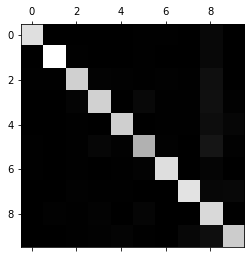

In [74]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

Most images/digits are classified correctly. Next we take a look into the errors by dividing each value of the confusion matrix by the number of corresponding images.

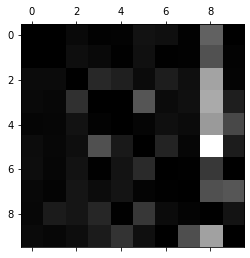

In [75]:
row_sums=conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx=conf_mx/row_sums

np.fill_diagonal(norm_conf_mx, 0) #fill diagonal with 0's to keep errors only
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In the confusion matrix rows represent actual classes and columns represent predictions. Many images get misclassified as 8. On the other hand 8's are classified correcty most of the time.  
3's and 5's are confused in both directions.

Examples of confused 3's and 5's

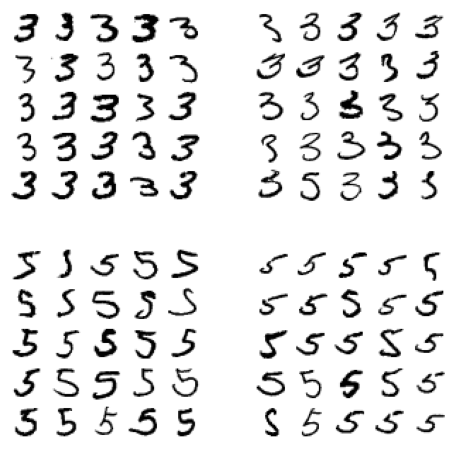

In [78]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")


cl_a, cl_b=3, 5
X_aa=X_train[(y_train==cl_a)&(y_train_pred==cl_a)]
X_ab=X_train[(y_train==cl_a)&(y_train_pred==cl_b)]
X_ba=X_train[(y_train==cl_b)&(y_train_pred==cl_a)]
X_bb=X_train[(y_train==cl_b)&(y_train_pred==cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

## Multilabel Classification

Example: Face regognition of multiple faces in one image

In [80]:
#create two labels
y_train_large=(y_train>=7) #first label: digit is larger than 7
y_train_odd=(y_train % 2 == 1) #second label: digit is odd
y_multilabel=np.c_[y_train_large, y_train_odd] #create multilabel array

knn_clf=KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel) #train classifier with multilabel

KNeighborsClassifier()

In [81]:
#For some_digit ('5') this classifier returns False forthe first label and True for the second label
knn_clf.predict([some_digit])

array([[False,  True]])

If all labels are equally important an average F1 score across all labels can be used for evaluation

In [82]:
y_train_knn_pred=cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

## Multioutput Classification

Example: Noise reduction: Array of pixel intensities --> output is multilabel (one label per pixel) and each pixel can have multiple values (pixel intensity from 0 to 255)

In [83]:
#put noise on mnist images to demonstrate noise reduction
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod=X_train+noise
noise=np.random.randint(0, 100, (len(X_test), 784))
X_test_mod=X_test+noise
y_train_mod=X_train
y_test_mod=X_test

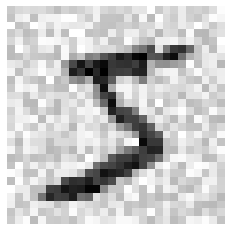

In [85]:
#Look into one of the noisy digits
some_noisy_digit=X_train_mod[0]
some_noisy_digit_image=some_noisy_digit.reshape(28,28)

plt.imshow(some_noisy_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [87]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([some_noisy_digit])


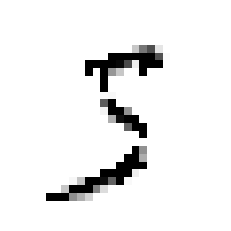

In [93]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")
    
plot_digit(clean_digit)